In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import sort
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import tree

# Data Cleaning

In [4]:
# read the raw data as dataframe
DLQ_I_df = pd.read_sas('DLQ_I.XPT')
DLQ_I_df = DLQ_I_df.fillna(0).astype(int) # convert to int type and fill the nan with 0
DUQ_I_df = pd.read_sas('DUQ_I.XPT')
DUQ_I_df = DUQ_I_df.fillna(0).astype(int)
HSQ_I_df = pd.read_sas('HSQ_I.XPT')
HSQ_I_df = HSQ_I_df.fillna(0).astype(int)
INQ_I_df = pd.read_sas('INQ_I.XPT')
INQ_I_df = INQ_I_df.fillna(0).astype(int)

# remove uninterested features or retain interested features
DUQ_I_df = pd.DataFrame(DUQ_I_df,columns=['SEQN','DUQ200','DUQ220U','DUQ240','DUQ270U','DUQ290','DUQ310U','DUQ330','DUQ350U','DUQ370','DUQ400U','DUQ430'])
HSQ_I_df=HSQ_I_df.drop(labels=['HSQ571','HSQ580','HSAQUEX',],axis=1)
INQ_I_df=INQ_I_df.drop(labels=['IND310','INDFMMPI'],axis=1)
DLQ_I_df =DLQ_I_df.drop(labels=['DLQ100','DLQ110','DLQ130','DLQ140','DLQ170'],axis=1)

# find common sequence
DLQ_I_n = set(DLQ_I_df['SEQN'].values.tolist())
DUQ_I_n = set(DUQ_I_df['SEQN'].values.tolist())
HSQ_I_n = set(HSQ_I_df['SEQN'].values.tolist())
INQ_I_n = set(INQ_I_df['SEQN'].values.tolist())
iset = DLQ_I_n.intersection(DUQ_I_n)
iset = iset.intersection(HSQ_I_n)
iset = iset.intersection(INQ_I_n)
common_seqns = list(iset)
common_seqns.sort()
INQ_I_cols = list(INQ_I_df.columns)
INQ_I_cols.remove('SEQN')
HSQ_I_cols = list(HSQ_I_df.columns)
HSQ_I_cols.remove('SEQN')
DUQ_I_cols = list(DUQ_I_df.columns)
DUQ_I_cols.remove('SEQN')
DLQ_I_cols = list(DLQ_I_df.columns)
DLQ_I_cols.remove('SEQN')
np.save("INQ_I_cols.npy",INQ_I_cols)
np.save("HSQ_I_cols.npy",HSQ_I_cols)
np.save("DUQ_I_cols.npy",DUQ_I_cols)
np.save("DLQ_I_cols.npy",DLQ_I_cols)


tot_cols = np.hstack(('SEQN',INQ_I_cols,HSQ_I_cols,DUQ_I_cols,DLQ_I_cols))
tot_df = pd.DataFrame(columns=tot_cols)
cnt1,cnt2,cnt3,cnt4,cnt5=0,0,0,0,0
for seqn in tqdm(common_seqns):
    flag = False
    tmp_INQ_I_values = INQ_I_df[INQ_I_df.SEQN==seqn][INQ_I_cols].values
    if sum(tmp_INQ_I_values[0])==0:
        flag = True
        cnt1+=1
    tmp_HSQ_I_values = HSQ_I_df[HSQ_I_df.SEQN==seqn][HSQ_I_cols].values
    if sum(tmp_HSQ_I_values[0])==0:
        flag = True
        cnt2+=1
    tmp_DUQ_I_values = DUQ_I_df[DUQ_I_df.SEQN==seqn][DUQ_I_cols].values
    if sum(tmp_DUQ_I_values[0])==0:
        flag = True
        cnt3+=1
    tmp_DLQ_I_values = DLQ_I_df[DLQ_I_df.SEQN==seqn][DLQ_I_cols].values
    if sum(tmp_DLQ_I_values[0])==0:
        flag = True
        cnt4+=1
    tot_values = np.hstack(([[seqn]],tmp_INQ_I_values,tmp_HSQ_I_values,tmp_DUQ_I_values,tmp_DLQ_I_values))
    if sum(tot_values[0])==0:
        flag = True
        cnt5+=1
    if not flag: # all data not missing
        tmp_df = pd.DataFrame(tot_values,columns=tot_cols)
        tot_df = tot_df.append(tmp_df)
print(cnt1,cnt2,cnt3,cnt4,cnt5)
print(f"tot numbers of people: {len(tot_df)}")
tot_df.to_csv('tot_df.csv',index=None)


100%|██████████| 4843/4843 [00:11<00:00, 431.32it/s]

158 483 583 0 0
tot numbers of people: 4132


In [5]:
DUQ_I_cols = np.load("DUQ_I_cols.npy")
tot_df = pd.read_csv('tot_df.csv')

DUQ_I_df = tot_df[['SEQN','DUQ200','DUQ220U','DUQ240','DUQ270U','DUQ290','DUQ310U','DUQ330','DUQ350U','DUQ370','DUQ400U']]
DUQ_I_new_df = pd.DataFrame(columns=['SEQN','no drug','marijuana','cocaine','heroin','methamphetamine','needle'])
cnt_missing=0
cnt_no_drug=0
for i in tqdm(range(len(DUQ_I_df))):
  tmp_values = DUQ_I_df.iloc[i].values[1:]
  if sum(tmp_values)==0: # all data is missing
    cnt_missing+=1
  else:
    if 1 not in tmp_values:
      cnt_no_drug+=1
      tmp_df = pd.DataFrame([[DUQ_I_df.iloc[i]['SEQN'],1,0,0,0,0,0]],columns=['SEQN','no drug','marijuana','cocaine','heroin','methamphetamine','needle'])
      DUQ_I_new_df = DUQ_I_new_df.append(tmp_df)
    else:
      tmp_list = []
      for i in range(0,len(tmp_values),2):
        if tmp_values[i]==2 or tmp_values[i]==0 :
          tmp_list.append(0)
        else:
          if tmp_values[i+1]==0:
            tmp_list.append(1)
          else:
            tmp_list.append(5-tmp_values[i+1]) # reverse the extent of drug use, the higher value, more frequently frug use
      tmp_df = pd.DataFrame([np.hstack((DUQ_I_df.iloc[i]['SEQN'],0,tmp_list))],columns=['SEQN','no drug','marijuana','cocaine','heroin','methamphetamine','needle'])
      DUQ_I_new_df = DUQ_I_new_df.append(tmp_df)
print(f"count no drug",cnt_no_drug)
DUQ_I_new_df.to_csv('DUQ_I_new_df.csv',index=None)



100%|██████████| 4132/4132 [00:03<00:00, 1331.54it/s]

count no drug 2286


In [6]:
DUQ_I_new_df = pd.read_csv('DUQ_I_new_df.csv')
DUQ_I_new_cols = DUQ_I_new_df.columns.tolist()
DUQ_I_new_cols.remove('SEQN')
DUQ_I_label_df = pd.DataFrame(columns=['SEQN',"DrugLabel"])
for i in tqdm(range(len(DUQ_I_new_df))):
    tmp_values = DUQ_I_new_df.iloc[i][DUQ_I_new_cols].values
    label = np.argmax(tmp_values)
    tmp_df = pd.DataFrame([[DUQ_I_new_df.iloc[i]['SEQN'],label]],columns=['SEQN',"DrugLabel"])
    DUQ_I_label_df = DUQ_I_label_df.append(tmp_df)
print(DUQ_I_label_df["DrugLabel"].value_counts(sort=False))
DUQ_I_label_df.to_csv('DUQ_I_label_df.csv',index=None)

100%|██████████| 4132/4132 [00:02<00:00, 1378.42it/s]

0    2286
1    1640
2     186
3       4
4      10
5       6
Name: DrugLabel, dtype: int64


In [7]:
dfQQ2=pd.read_csv('DUQ_I_label_df.csv')
dfQQ2.head(5)

,SEQN,DrugLabel
0,83750,2
1,83733,0
2,83735,0
3,83750,1
4,83750,1


# Data Analysis

## Drug Income

  IND235 no drug marijuana cocaine heroin methamphetamine needle
0      1      65        71      28      4              11      4
0      2      88        70      43     10              11      8
0      3     207       126      67      9              20     15
0      4     141       115      49      6              15      8
0      5     190       119      46     10              11      7
0      6     175       156      61     12              33      6
0      7     254       181      62      6              23      4
0      8     214       144      50      4              18      7
0      9     136       101      34      2               8      3
0     10     116       128      39      3              17      2
0     11     164       102      43      2              20      6
0     12     240       201      73      6              26      6
   IND235  no drug  marijuana  cocaine  heroin  methamphetamine  needle
0     1.0     0.47       0.51     0.20    0.03             0.08    0.03
0     2.0  

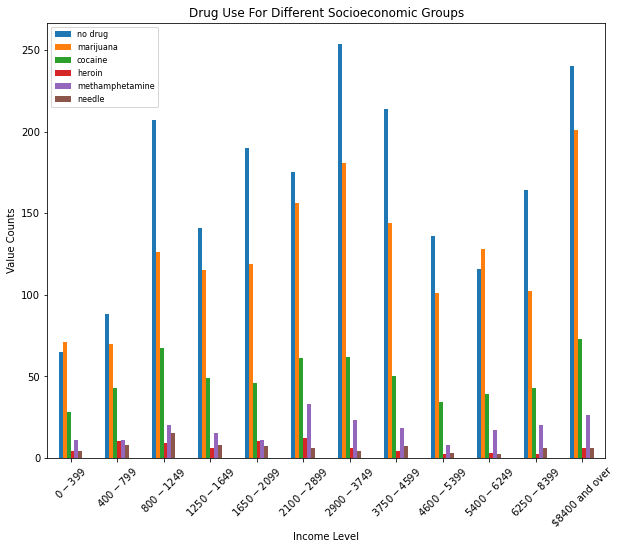

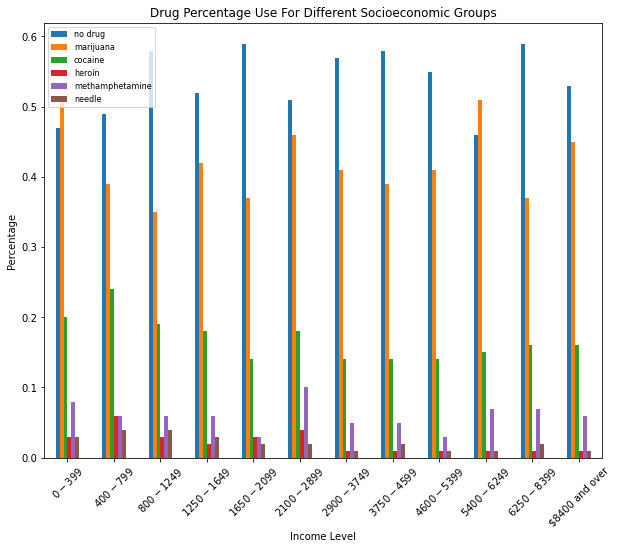

In [8]:
INQ_I_cols = np.load("INQ_I_cols.npy")
tot_df = pd.read_csv('tot_df.csv')
DUQ_I_new_df = pd.read_csv('DUQ_I_new_df.csv')
DUQ_I_new_cols = DUQ_I_new_df.columns.tolist()
DUQ_I_new_cols.remove('SEQN')
INQ_I_df = tot_df['IND235']
INQ_DUQ_I_df = pd.concat([DUQ_I_new_df,INQ_I_df], axis=1)
INQ_DUQ_I_df = INQ_DUQ_I_df.sort_values(by=['IND235'])
INQ_DUQ_I_df = INQ_DUQ_I_df[(INQ_DUQ_I_df['IND235']>=1) & (INQ_DUQ_I_df['IND235']<=12)]
INQ_DUQ_I_df= INQ_DUQ_I_df.drop(labels=['SEQN'],axis=1)
# INQ_DUQ_I_df = tot_df[np.hstack(('SEQN','IND235',DUQ_I_cols))]
# INQ_DUQ_I_df = INQ_DUQ_I_df.sort_values(by=['IND235'])
# INQ_DUQ_I_df = INQ_DUQ_I_df[INQ_DUQ_I_df.IND235>=1].reset_index(drop=True)

tmp_cnt_df = pd.DataFrame(columns=np.hstack(('IND235',DUQ_I_new_cols)))
tmp_percent_cnt_df = pd.DataFrame(columns=np.hstack(('IND235',DUQ_I_new_cols)))
for num in INQ_DUQ_I_df['IND235'].unique():
    tmp_INQ_DUQ_I_df = INQ_DUQ_I_df[INQ_DUQ_I_df.IND235==num]
    tmp_list = []
    tmp_percent_list = []
    for col in DUQ_I_new_cols:
        tmp_list.append(len(tmp_INQ_DUQ_I_df)-tmp_INQ_DUQ_I_df[col].value_counts()[0])
        tmp_percent_list.append(round((len(tmp_INQ_DUQ_I_df)-tmp_INQ_DUQ_I_df[col].value_counts()[0])/len(tmp_INQ_DUQ_I_df),2))
#         
    tmp_df = pd.DataFrame([np.hstack(([num],tmp_list))],columns=np.hstack(('IND235',DUQ_I_new_cols)))
    tmp_cnt_df = tmp_cnt_df.append(tmp_df)
    tmp_percent_df = pd.DataFrame([np.hstack(([num],tmp_percent_list))],columns=np.hstack(('IND235',DUQ_I_new_cols)))
    tmp_percent_cnt_df = tmp_percent_cnt_df.append(tmp_percent_df)
print(tmp_cnt_df)
print(tmp_percent_cnt_df)

ax_INC=tmp_cnt_df.plot(x="IND235", y=DUQ_I_new_cols ,kind='bar',figsize=(10,8))
plt.legend(loc=2,fontsize=8)
ax_INC.set_xticklabels(labels=['$0-$399', '$400-$799','$800-$1249','$1250-$1649',
                  '$1650-$2099','$2100-$2899','$2900-$3749','$3750-$4599',
                  '$4600-$5399','$5400-$6249','$6250-$8399','$8400 and over'],
       rotation=45, fontsize=10)
plt.savefig('income_drug_pro.png')
plt.title("Drug Use For Different Socioeconomic Groups")
plt.xlabel("Income Level")
plt.ylabel("Value Counts")
plt.show()

ax_INC_precentage=tmp_percent_cnt_df.plot(x="IND235", y=DUQ_I_new_cols ,kind='bar',figsize=(10,8))
plt.legend(loc=2,fontsize=8)
ax_INC_precentage.set_xticklabels(labels=['$0-$399', '$400-$799','$800-$1249','$1250-$1649',
                  '$1650-$2099','$2100-$2899','$2900-$3749','$3750-$4599',
                  '$4600-$5399','$5400-$6249','$6250-$8399','$8400 and over'],
       rotation=45, fontsize=10)

plt.title("Drug Percentage Use For Different Socioeconomic Groups")
plt.xlabel("Income Level")
plt.ylabel("Percentage")
plt.savefig('income_drug_pro_percent.png')
plt.show()


In [9]:
tmp_cnt_df

,IND235,no drug,marijuana,cocaine,heroin,methamphetamine,needle
0,1,65,71,28,4,11,4
0,2,88,70,43,10,11,8
0,3,207,126,67,9,20,15
0,4,141,115,49,6,15,8
0,5,190,119,46,10,11,7
0,6,175,156,61,12,33,6
0,7,254,181,62,6,23,4
0,8,214,144,50,4,18,7
0,9,136,101,34,2,8,3
0,10,116,128,39,3,17,2


In [10]:
DUQ_I_label_df = pd.read_csv('DUQ_I_label_df.csv')
DUQ_I_label_cols = DUQ_I_label_df.columns.tolist()
DUQ_I_label_cols.remove('SEQN')
DLQ_I_cols = np.load("DLQ_I_cols.npy")
tot_df = pd.read_csv('tot_df.csv')
DLQ_I_df = tot_df[DLQ_I_cols]
DLQ_DUQ_I_label_df = pd.concat([DLQ_I_df,DUQ_I_label_df[DUQ_I_label_cols]], axis=1)
tmp_cols_DLQ = DLQ_DUQ_I_label_df.columns.tolist()
tmp_cols_DLQ.remove('DrugLabel')
# print(DLQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))

# for label in DLQ_DUQ_I_label_df['DrugLabel'].unique():
#     tmp_list = []
#     tmp_df = DLQ_DUQ_I_label_df[DLQ_DUQ_I_label_df['DrugLabel']==label]
#     for col in tmp_cols:
#         tmp_list.append(round((tmp_df[col].value_counts()[1])/len(tmp_df),2))
#     print(label,tmp_list)

for col in DLQ_DUQ_I_label_df.columns:
    DLQ_DUQ_I_label_df= DLQ_DUQ_I_label_df[DLQ_DUQ_I_label_df[col]<=2]
# print(DLQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))
print('  DLQ010: Have serious difficulty hearing?','\n',
' DLQ020: Have serious difficulty seeing?','\n',
' DLQ040: Have serious difficulty concentrating?','\n',
' DLQ050: Have serious difficulty walking?','\n',
' DLQ060: Have difficulty dressing or bathing?','\n',
' DLQ080: Have difficulty doing errands alone?','\n',
' DLQ150: Take medication for depression?')
print(' ',tmp_cols_DLQ)
for label in DLQ_DUQ_I_label_df['DrugLabel'].unique():
    tmp_list = []
    tmp_df = DLQ_DUQ_I_label_df[DLQ_DUQ_I_label_df['DrugLabel']==label]
    for col in tmp_cols_DLQ:
        tmp_list.append(round((tmp_df[col].value_counts()[1])/len(tmp_df),2))
    print(label,tmp_list)


  DLQ010: Have serious difficulty hearing? 
  DLQ020: Have serious difficulty seeing? 
  DLQ040: Have serious difficulty concentrating? 
  DLQ050: Have serious difficulty walking? 
  DLQ060: Have difficulty dressing or bathing? 
  DLQ080: Have difficulty doing errands alone? 
  DLQ150: Take medication for depression?
  ['DLQ010', 'DLQ020', 'DLQ040', 'DLQ050', 'DLQ060', 'DLQ080', 'DLQ150']
2 [0.08, 0.08, 0.16, 0.25, 0.07, 0.08, 0.17]
0 [0.06, 0.04, 0.08, 0.12, 0.04, 0.05, 0.07]
1 [0.05, 0.05, 0.11, 0.09, 0.04, 0.07, 0.11]


In [11]:
from xgboost import XGBClassifier 
from xgboost import plot_tree
from sklearn.neural_network import MLPClassifier
X_1 = DLQ_DUQ_I_label_df[DLQ_I_cols].values
y_1 = DLQ_DUQ_I_label_df['DrugLabel'].values
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.2, random_state = 0)
model_XGBoost_Drug = XGBClassifier(learning_rate=0.005,
                      use_label_encoder=False,
                      n_estimators=200,           # number of tree, every 10 tree set up xgboost
                      max_depth=4,                # depth of tree
                      min_child_weight = 1,       # "1": for every child need 100 sample, get the weight of child
                      gamma=0.,                   # parameters
                      subsample=1,                # set up the decision tree by all sample
                      random_state=1,             # random number
                      )
model_XGBoost_Drug.fit(X_train_1,y_train_1)
y_pred_1 = model_XGBoost_Drug.predict(X_test_1)
accuracy_XGBoost_drug = accuracy_score(y_test_1, y_pred_1)
print("Accuracy of XGBT:", accuracy_XGBoost_drug)

model_DNN_Drug = MLPClassifier(hidden_layer_sizes=(64), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001, power_t=0.5, max_iter=400 ,tol=1e-4)

model_DNN_Drug.fit(X_train_1,y_train_1)
y_pred_1 = model_DNN_Drug.predict(X_test_1)
accuracy_DNN_drug = accuracy_score(y_test_1, y_pred_1)
print("Accuracy of DNN:", accuracy_DNN_drug)




[19:56:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBT: 0.5785627283800243
Accuracy of DNN: 0.5773447015834349


In [ ]:
X_1 = DLQ_DUQ_I_label_df[DLQ_I_cols]

X_1

In [ ]:
y_1 = DLQ_DUQ_I_label_df['DrugLabel'].values

## Drug Health Status

In [471]:
#INQ_I_df_Inc_saving=INQ_I_df.drop(labels=['INQ020','INQ012','INQ030','INQ060','INQ080','INQ090','INQ132',
#                      'INQ140','INQ150','INQ300','INDFMMPC'],axis=1)
INQ_I_df_Inc_saving

,IND235
0,10
1,1
2,7
3,7
4,9
...,...
4127,3
4128,12
4129,10
4130,8


In [449]:
DUQ_I_label_df = pd.read_csv('DUQ_I_label_df.csv')
DUQ_I_label_cols = DUQ_I_label_df.columns.tolist()
DUQ_I_label_cols.remove('SEQN')
HSQ_I_cols = np.load("HSQ_I_cols.npy")
tot_df = pd.read_csv('tot_df.csv')
DLQ_I_df = tot_df[HSQ_I_cols]
HSQ_DUQ_I_label_df = pd.concat([DLQ_I_df,DUQ_I_label_df[DUQ_I_label_cols]], axis=1)
#no General
HSQ_DUQ_I_label_df_noGen=HSQ_DUQ_I_label_df.drop(labels=['HSD010'],axis=1)
#only General
HSQ_DUQ_I_label_df_Gen=HSQ_DUQ_I_label_df.drop(labels=['HSQ500','HSQ510','HSQ520','HSQ590'],axis=1)
#tmp_cols_HSD = HSQ_DUQ_I_label_df.columns.tolist()
#tmp_cols_HSD.remove('DrugLabel')
## print(HSQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))

#for col in HSQ_DUQ_I_label_df.columns:
#    HSQ_DUQ_I_label_df= HSQ_DUQ_I_label_df[HSQ_DUQ_I_label_df[col]<=5]
## print(HSQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))

#for label in HSQ_DUQ_I_label_df['DrugLabel'].unique():
#    tmp_list = []
#    tmp_df = HSQ_DUQ_I_label_df[HSQ_DUQ_I_label_df['DrugLabel']==label]


#    for c in tmp_cols_HSD:
#        tmp_dict = dict(tmp_df[c].value_counts())
#        for key,value in tmp_dict.items():
#            tmp_dict[key] = round(value/sum(dict(tmp_df[c].value_counts(sort=False)).values()),2)
#        tmp_list.append({c:tmp_dict})
    
#        # tmp_list.append(round((len(tmp_df)-tmp_df[col].value_counts()[1])/len(tmp_df),2))
#    print(label,tmp_list,'\n')


In [450]:
tmp_cols_HSD = HSQ_DUQ_I_label_df_noGen.columns.tolist()
tmp_cols_HSD.remove('DrugLabel')
# print(HSQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))

for col in HSQ_DUQ_I_label_df_noGen.columns:
    HSQ_DUQ_I_label_df_noGen= HSQ_DUQ_I_label_df_noGen[HSQ_DUQ_I_label_df_noGen[col]<=5]
# print(HSQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))

for label in HSQ_DUQ_I_label_df_noGen['DrugLabel'].unique():
    tmp_list = []
    tmp_df = HSQ_DUQ_I_label_df_noGen[HSQ_DUQ_I_label_df_noGen['DrugLabel']==label]


    for c in tmp_cols_HSD:
        tmp_dict = dict(tmp_df[c].value_counts())
        for key,value in tmp_dict.items():
            tmp_dict[key] = round(value/sum(dict(tmp_df[c].value_counts(sort=False)).values()),2)
        tmp_list.append({c:tmp_dict})
    
        # tmp_list.append(round((len(tmp_df)-tmp_df[col].value_counts()[1])/len(tmp_df),2))
    print(label,tmp_list,'\n')

2 [{'HSQ500': {2: 0.79, 1: 0.21}}, {'HSQ510': {2: 0.93, 1: 0.07}}, {'HSQ520': {2: 0.93, 1: 0.07}}, {'HSQ590': {1: 0.51, 2: 0.49}}] 

0 [{'HSQ500': {2: 0.84, 1: 0.16}}, {'HSQ510': {2: 0.94, 1: 0.06}}, {'HSQ520': {2: 0.96, 1: 0.04}}, {'HSQ590': {2: 0.66, 1: 0.34}}] 

1 [{'HSQ500': {2: 0.83, 1: 0.17}}, {'HSQ510': {2: 0.91, 1: 0.09}}, {'HSQ520': {2: 0.97, 1: 0.03}}, {'HSQ590': {1: 0.52, 2: 0.48}}] 

5 [{'HSQ500': {2: 0.67, 1: 0.33}}, {'HSQ510': {2: 1.0}}, {'HSQ520': {2: 0.83, 1: 0.17}}, {'HSQ590': {1: 0.67, 2: 0.33}}] 

3 [{'HSQ500': {2: 1.0}}, {'HSQ510': {2: 1.0}}, {'HSQ520': {2: 1.0}}, {'HSQ590': {1: 0.5, 2: 0.5}}] 

4 [{'HSQ500': {2: 0.7, 1: 0.3}}, {'HSQ510': {2: 0.6, 1: 0.4}}, {'HSQ520': {2: 0.9, 1: 0.1}}, {'HSQ590': {1: 0.8, 2: 0.2}}] 



In [451]:
#  only HSQ_DUQ_I_label_df General health condition
tmp_cols_HSD_GEN = HSQ_DUQ_I_label_df_Gen.columns.tolist()
tmp_cols_HSD_GEN.remove('DrugLabel')
# print(HSQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))

for col in HSQ_DUQ_I_label_df_Gen.columns:
    HSQ_DUQ_I_label_df_Gen= HSQ_DUQ_I_label_df_Gen[HSQ_DUQ_I_label_df_Gen[col]<=5]
# print(HSQ_DUQ_I_label_df['DrugLabel'].value_counts(sort=False))

for label in HSQ_DUQ_I_label_df_Gen['DrugLabel'].unique():
    tmp_list = []
    tmp_df = HSQ_DUQ_I_label_df_Gen[HSQ_DUQ_I_label_df_Gen['DrugLabel']==label]


    for c in tmp_cols_HSD_GEN:
        tmp_dict = dict(tmp_df[c].value_counts())
        for key,value in tmp_dict.items():
            tmp_dict[key] = round(value/sum(dict(tmp_df[c].value_counts(sort=False)).values()),2)
        tmp_list.append({c:tmp_dict})
    
        # tmp_list.append(round((len(tmp_df)-tmp_df[col].value_counts()[1])/len(tmp_df),2))
    print(label,tmp_list,'\n')

2 [{'HSD010': {3: 0.43, 4: 0.31, 2: 0.16, 5: 0.06, 1: 0.05}}] 

0 [{'HSD010': {3: 0.41, 2: 0.25, 4: 0.23, 1: 0.09, 5: 0.03}}] 

1 [{'HSD010': {3: 0.42, 2: 0.28, 4: 0.19, 1: 0.08, 5: 0.03}}] 

5 [{'HSD010': {2: 0.5, 1: 0.33, 4: 0.17}}] 

3 [{'HSD010': {4: 0.5, 3: 0.5}}] 

4 [{'HSD010': {4: 0.4, 3: 0.3, 1: 0.1, 2: 0.1, 5: 0.1}}] 



In [452]:
from xgboost import XGBClassifier 
from sklearn.neural_network import MLPClassifier

X = HSQ_DUQ_I_label_df[HSQ_I_cols].values
y = HSQ_DUQ_I_label_df['DrugLabel'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
model_XGBoost = XGBClassifier(learning_rate=0.005,
                      use_label_encoder=False,
                      n_estimators=200,           # number of tree, every 10 tree set up xgboost
                      max_depth=4,                # depth of tree
                      min_child_weight = 1,       # "1": for every child need 100 sample, get the weight of child
                      gamma=0.,                   # parameters
                      subsample=1,                # set up the decision tree by all sample
                      random_state=1,             # random number
                      )
model_XGBoost.fit(X_train,y_train)
y_pred = model_XGBoost.predict(X_test)
accuracy_XGBoost = accuracy_score(y_test, y_pred)
print("Accuracy of XGBT:",accuracy_XGBoost)

model_DNN = MLPClassifier(hidden_layer_sizes=(64), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001, power_t=0.5, max_iter=400 ,tol=1e-4)

model_DNN.fit(X_train,y_train)
y_pred = model_DNN.predict(X_test)
accuracy_DNN = accuracy_score(y_test, y_pred)
print("Acc of DNN:", accuracy_DNN)

[23:41:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBT: 0.5743651753325272
Acc of DNN: 0.5610640870616687


# Data Visualization

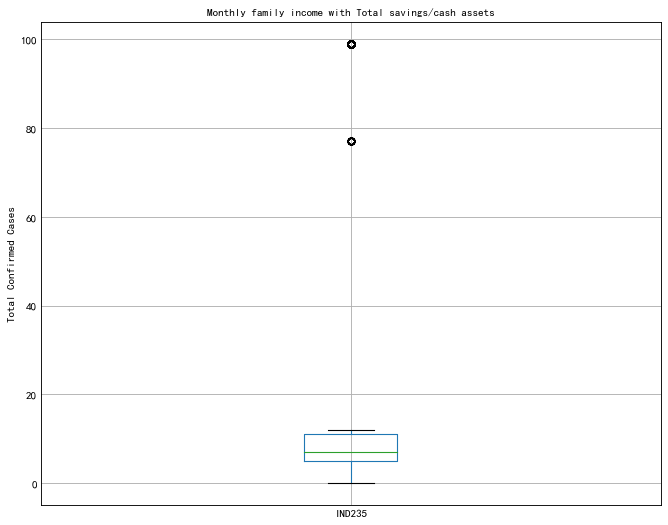

In [453]:
tot_df = pd.read_csv('tot_df.csv')
tot_df =tot_df.drop(labels=['SEQN'],axis=1)
INQ_I_cols = np.load('INQ_I_cols.npy')
INQ_I_df = tot_df[INQ_I_cols]
INQ_I_df_Inc_saving=INQ_I_df.drop(labels=['INQ020','INQ012','INQ030','INQ060','INQ080','INQ090','INQ132',
                      'INQ140','INQ150','INQ300','INDFMMPC','INQ320'],axis=1)
plt.figure(figsize=(10,8), dpi= 80) 
INQ_I_df_Inc_saving.boxplot()
plt.tick_params(labelsize=10)
plt.title("Monthly family income with Total savings/cash assets")
plt.xlabel("")
plt.ylabel("Total Confirmed Cases")
plt.savefig('INC-savings-df.png',dpi=600)


In [ ]:
INQ_I_df

In [454]:
INQ_I_df_INCOME=INQ_I_df['IND235'].reset_index()
INQ_I_df_INCOME=INQ_I_df_INCOME.drop(labels='index',axis=1)
tem_income_table=INQ_I_df_INCOME.value_counts().reset_index()
tem_income_table=tem_income_table.rename(columns={'IND235': 'income_value', 0: 'Counts'})
tem_income_table=tem_income_table.sort_values(by='income_value')
tem_income_table=tem_income_table.drop([14,13,4])
tem_income_table

,income_value,Counts
12,1,139
11,2,178
3,3,359
8,4,271
6,5,324
5,6,342
1,7,446
2,8,367
10,9,247
9,10,252


/Users/yutingguo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


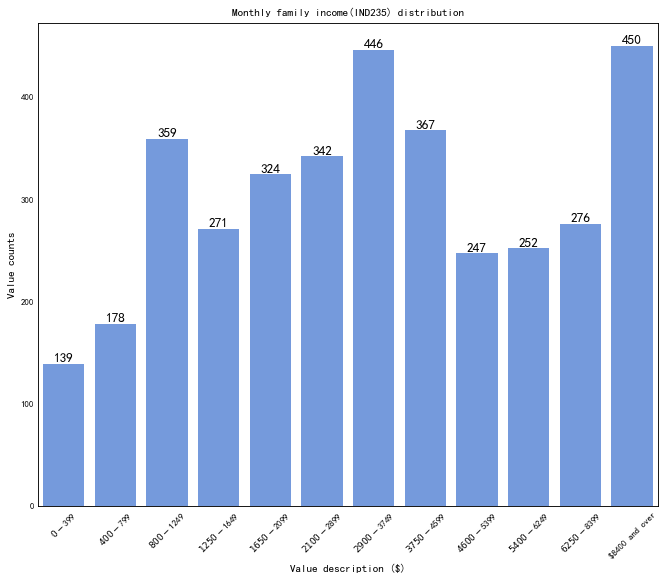

In [455]:
A=tem_income_table['income_value']
B=tem_income_table['Counts']
plt.figure(figsize=(10,8), dpi= 80) 

ax=sns.barplot("income_value", "Counts", data=tem_income_table,color='#6495ED')


for a, b in zip(A, B):
    plt.text(a-1, b, b, ha='center', va='bottom', fontsize=12)

plt.title("Monthly family income(IND235) distribution")
plt.xlabel("Value description ($)")
plt.ylabel("Value counts")
ax.set_xticklabels(labels=['$0-$399', '$400-$799','$800-$1249','$1250-$1649',
                  '$1650-$2099','$2100-$2899','$2900-$3749','$3750-$4599',
                  '$4600-$5399','$5400-$6249','$6250-$8399','$8400 and over'],
       rotation=45, fontsize=8)

plt.savefig('INC-Income-barplot.png',dpi=600)

In [456]:
INQ_I_df.head(5)

,INQ020,INQ012,INQ030,INQ060,INQ080,INQ090,INQ132,INQ140,INQ150,IND235,INDFMMPC,INQ300,INQ320
0,1,2,2,2,2,2,2,1,2,10,3,1,1
1,1,2,2,2,2,2,2,2,2,1,1,2,1
2,1,2,2,2,2,2,2,1,2,7,3,2,1
3,1,1,2,2,2,2,2,2,2,7,2,2,1
4,1,2,2,2,2,2,2,2,1,9,3,2,1


In [457]:
INQ_I_df['INQ020'].value_counts()

1    3489
2     603
9      27
7      13
Name: INQ020, dtype: int64

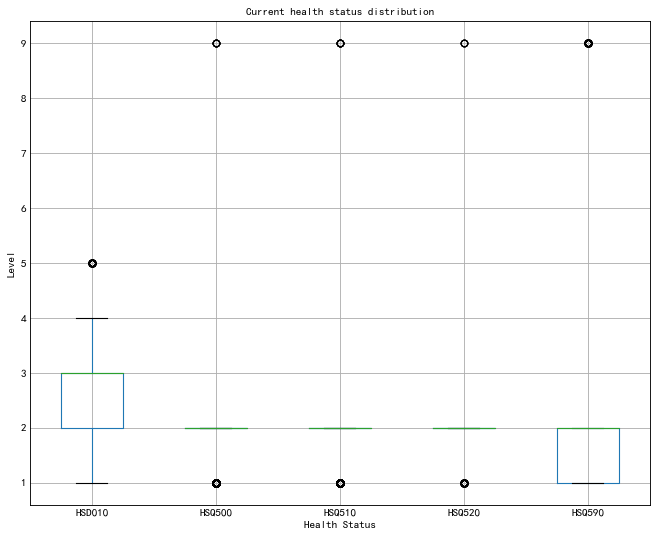

In [458]:
HSQ_I_cols = np.load('HSQ_I_cols.npy')
HSQ_I_df = tot_df[HSQ_I_cols]
plt.figure(figsize=(10,8), dpi= 80)
ax_1=HSQ_I_df.boxplot()
#ax.set_yticklabels()
plt.tick_params(labelsize=10)
plt.title("Current health status distribution")
plt.xlabel("Health Status")
plt.ylabel("Level")
plt.savefig('HSQ-I-df.png',dpi=600)

In [459]:
HSQ_I_df_HSD010=HSQ_I_df['HSD010'].value_counts().reset_index()
HSQ_I_df_HSQ500=HSQ_I_df['HSQ500'].value_counts().reset_index()
HSQ_I_df_HSQ510=HSQ_I_df['HSQ510'].value_counts().reset_index()
HSQ_I_df_HSQ520=HSQ_I_df['HSQ520'].value_counts().reset_index()
HSQ_I_df_HSQ590=HSQ_I_df['HSQ590'].value_counts().reset_index()


In [460]:
HSQ_I_df_HSQ590_T=np.transpose(HSQ_I_df_HSQ590)
new_header = HSQ_I_df_HSQ590_T.iloc[0] #grab the first row for the header
HSQ_I_df_HSQ590_T = HSQ_I_df_HSQ590_T[1:] #take the data less the header row
HSQ_I_df_HSQ590_T.columns = new_header #set the header row as the df header
HSQ_I_df_HSQ590_T

HSQ_I_df_HSQ520_T=np.transpose(HSQ_I_df_HSQ520)
new_header2 = HSQ_I_df_HSQ520_T.iloc[0] #grab the first row for the header
HSQ_I_df_HSQ520_T = HSQ_I_df_HSQ520_T[1:] #take the data less the header row
HSQ_I_df_HSQ520_T.columns = new_header #set the header row as the df header
HSQ_I_df_HSQ510_T

HSQ_I_df_HSQ510_T=np.transpose(HSQ_I_df_HSQ510)
new_header1 = HSQ_I_df_HSQ510_T.iloc[0] #grab the first row for the header
HSQ_I_df_HSQ510_T = HSQ_I_df_HSQ510_T[1:] #take the data less the header row
HSQ_I_df_HSQ510_T.columns = new_header #set the header row as the df header
HSQ_I_df_HSQ510_T

HSQ_I_df_HSQ500_T=np.transpose(HSQ_I_df_HSQ500)
new_header0 = HSQ_I_df_HSQ500_T.iloc[0] #grab the first row for the header
HSQ_I_df_HSQ500_T = HSQ_I_df_HSQ500_T[1:] #take the data less the header row
HSQ_I_df_HSQ500_T.columns = new_header #set the header row as the df header
HSQ_I_df_HSQ500_T

frame1 = [HSQ_I_df_HSQ500_T,HSQ_I_df_HSQ510_T,HSQ_I_df_HSQ510_T,HSQ_I_df_HSQ590_T]
HSQ_I_df_LONG=pd.concat(frame1)
#HSQ_I_df_LONG_T=HSQ_I_df_LONG.transpose()
HSQ_I_df_LONG

index,2,1,9
HSQ500,3426,700,6
HSQ510,3828,297,7
HSQ510,3828,297,7
HSQ590,2301,1682,149


/Users/yutingguo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


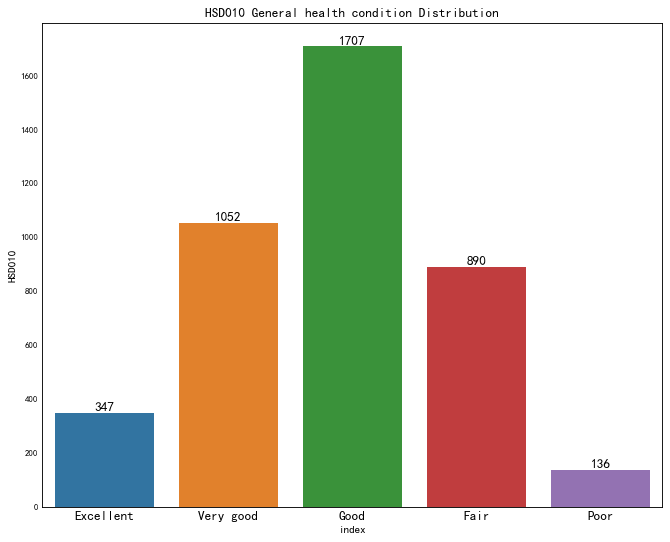

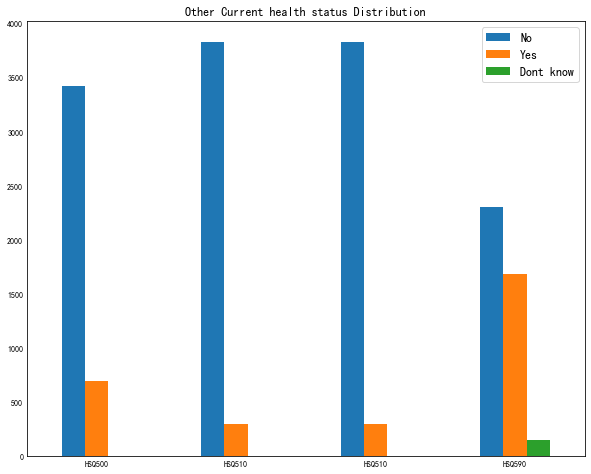

In [461]:
# HSD010 General health condition Distribution
plt.figure(figsize=(10,8), dpi= 80)
axHSQ1=sns.barplot("index","HSD010", data=HSQ_I_df_HSD010)
A1=HSQ_I_df_HSD010['index']
B1=HSQ_I_df_HSD010['HSD010']
for a, b in zip(A1, B1):
    plt.text(a-1, b, b, ha='center', va='bottom', fontsize=12)
axHSQ1.set_xticklabels(labels=['Excellent', 'Very good','Good','Fair','Poor'],
                       rotation=0, fontsize=12)
axHSQ1.set_title('HSD010 General health condition Distribution',fontsize=12)
plt.savefig('HSD010 General health condition Distribution.png',dpi=600)

# Other Current health status DLQ-I-df.pngistribution

HSQ_I_df_LONG.columns = ['No','Yes','Dont know']
axHSQ2 = HSQ_I_df_LONG.plot.bar(rot=0,figsize=(10,8))
axHSQ2.set_title('Other Current health status Distribution',fontsize=12)
plt.savefig('Other Current health status Distribution.png',dpi=600)

plt.show()


In [462]:
HSQ_I_df
new_header = HSQ_I_df_HSQ590.iloc[0] #grab the first row for the header
HSQ_I_df_HSQ590 = HSQ_I_df_HSQ590[1:] #take the data less the header row
HSQ_I_df_HSQ590.columns = new_header #set the header row as the df header
HSQ_I_df_HSQ590.head(10)

,2,2301
1,1,1682
2,9,149


3

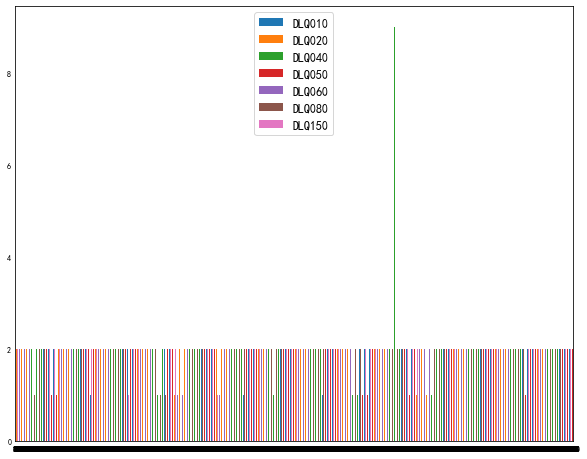

In [490]:
DLQ_I_df
axDLQ = DLQ_I_df.plot.bar(rot=0,figsize=(10,8))
plt.show()

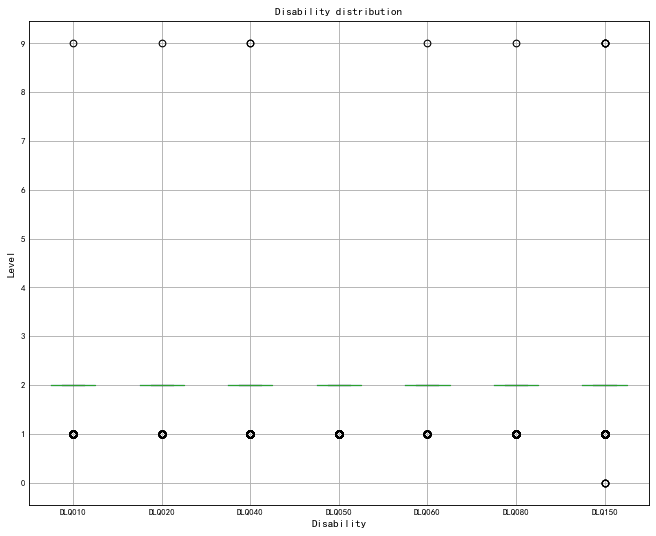

In [464]:
DLQ_I_cols = np.load('DLQ_I_cols.npy')
DLQ_I_df = tot_df[DLQ_I_cols]
plt.figure(figsize=(10,8), dpi= 80)
DLQ_I_df.boxplot()
plt.tick_params(labelsize=8)
plt.title("Disability distribution")
plt.xlabel("Disability")
plt.ylabel("Level")
plt.yticks(np.arange(0,10,1))
plt.savefig('DLQ-I-df.png',dpi=600)

In [465]:
DLQ_I_df.value_counts()

DLQ010  DLQ020  DLQ040  DLQ050  DLQ060  DLQ080  DLQ150
2       2       2       2       2       2       2         3034
                                                1          158
                        1       2       2       2          137
                1       2       2       2       2           97
1       2       2       2       2       2       2           83
                                                          ... 
2       2       1       2       2       1       0            1
1       2       1       1       2       1       2            1
2       2       1       2       2       2       0            1
1       2       1       1       1       2       2            1
9       1       2       2       2       2       2            1
Length: 104, dtype: int64

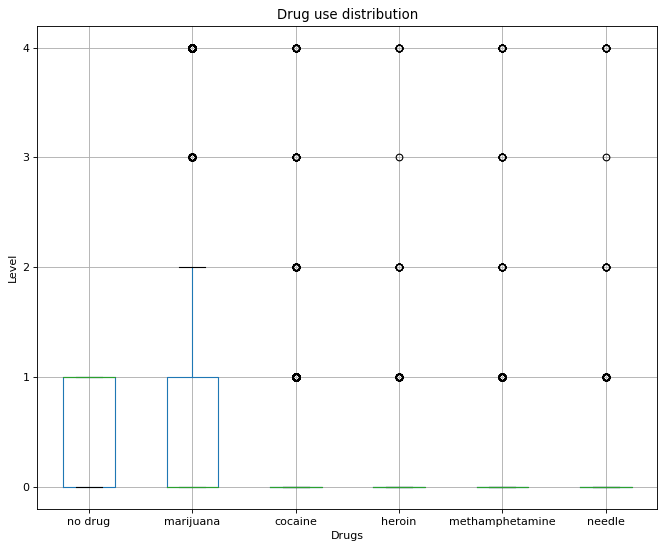

In [247]:

DUQ_I_new_df = pd.read_csv('DUQ_I_new_df.csv')
DUQ_I_new_cols = DUQ_I_new_df.columns.tolist()
DUQ_I_new_cols.remove('SEQN')
DUQ_I_new_df = DUQ_I_new_df[DUQ_I_new_cols]
plt.figure(figsize=(10,8), dpi= 80)
DUQ_I_new_df.boxplot()
#plt.tick_params(labelsize=10)
plt.title("Drug use distribution")
plt.xlabel("Drugs")
plt.ylabel("Level")
plt.yticks(np.arange(0,5,1))
plt.savefig('DUQ-I-new-df.png',dpi=600)

In [466]:
DUQ_I_new_df

,SEQN,no drug,marijuana,cocaine,heroin,methamphetamine,needle
0,83750,0,0,1,0,1,0
1,83733,1,0,0,0,0,0
2,83735,1,0,0,0,0,0
3,83750,0,4,0,0,0,0
4,83750,0,4,0,0,0,0
...,...,...,...,...,...,...,...
4127,93689,1,0,0,0,0,0
4128,83750,0,1,1,0,1,0
4129,93691,1,0,0,0,0,0
4130,93696,1,0,0,0,0,0
